<a href="https://colab.research.google.com/github/pronoysikdar/google-genai/blob/main/quickstarts/Search_Grounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [1]:
%pip install -U -q google-genai

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('Gemini-Colab-Experiments')

### Initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

In [5]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL="gemini-2.0-flash" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [8]:
from IPython.display import HTML
response = client.models.generate_content(
    model=MODEL,
    contents="What's BlackRock's latest AUM?",
    config={"tools": [{"google_search": {}}]},
)

# print the response
print(f"Response: {response.text}")
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")
display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response: BlackRock's most recent reported Assets Under Management (AUM) reached $11.55 trillion as of January 15, 2025.

Search Query: ['BlackRock AUM latest']
Search Pages: investopedia.com


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25), which includes the latest knowledge cutoff date.

In [9]:
response = client.models.generate_content(
    model=MODEL,
    contents='What was the latest Indian Premier League match and who won?',
)

# print the response
print(f"Response: {response.text}")

Response: As of October 28, 2024, the latest IPL match was **Match 69 between Rajasthan Royals (RR) and Royal Challengers Bengaluru (RCB). RCB won the match by 4 wickets.**



## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [10]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [12]:
chat = client.chats.create(model=MODEL)

r = chat.send_message('What is the latest daily return on Silver prices, meausred in US Dollars?')
show_parts(r)

I am unable to provide you with real-time, up-to-the-minute stock market data. This kind of information changes constantly.

However, you can find the latest daily return on silver prices (in USD) from these reliable sources:

*   **Financial News Websites:** Major financial news outlets like Bloomberg, Reuters, MarketWatch, CNBC, and Yahoo Finance have sections dedicated to commodity prices, including silver. They will show the current price and the daily change (in both USD and percentage).
*   **Financial Data Providers:** Services like Google Finance, TradingView, and others provide real-time or near real-time market data.
*   **Brokerage Platforms:** If you have a brokerage account, you can usually find the latest silver prices on their platform.

When you look up the information, make sure to specify that you want the price in USD (United States Dollars). Also, be mindful of the time zone, as "daily return" usually refers to the change from the previous day's close.

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [16]:
search_tool = {'google_search': {}}
soccer_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = soccer_chat.send_message("Who won the most recent Australia vs Chinese Taipei games?")
show_parts(r)

Based on the search results, here's the information on the most recent Australia vs. Chinese Taipei (women's) games:

*   **December 7, 2024:** Australia won 6-0 against Chinese Taipei.
*   **December 4, 2024:** Australia won 3-1 against Chinese Taipei.

Therefore, Australia won the two most recent games against Chinese Taipei.


As you are using a `chat` session, you can ask the model follow-up questions too.

In [17]:
r = soccer_chat.send_message('Who scored the goals?')
show_parts(r)

Here's a breakdown of the goal scorers for each game:

**December 7, 2024: Australia 6 - Chinese Taipei 0**

*   **Leah Davidson:** Scored her first international goal with a header.
*   **Tameka Yallop:** Scored with a left-footed shot.
*   **Emily Gielnik:** Scored with a header.
*   **Michelle Heyman:** Scored after a cutback pass from Remy Siemsen.
*   **Tash Prior:** Scored with a header from a free-kick by Emily van Egmond.
*   **Sharn Freier:** Scored after a cross-field ball from Winonah Heatley.

**December 4, 2024: Australia 3 - Chinese Taipei 1**

*   **Natasha Prior:** Volleyed in her first international goal from a cross by Chloe Logarzo.
*   **Sharn Freier:** Headed in a rebound after a shot from Emily Gielnik hit the crossbar.
*   **Bryleeh Henry:** Headed in a cross from Tameka Yallop.
*   **Chen Jin-Wen:** Scored for Chinese Taipei.


## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [18]:
movie_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')
show_parts(r)

```python
import matplotlib.pyplot as plt

# Movie titles and runtimes in minutes
movies = [
    "Dune: Part Two",
    "Dune: Part One",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Enemy",
    "Prisoners",
    "Incendies",
    "Polytechnique",
    "Maelstrom"
]

runtimes = [
    166, #Dune: Part Two
    155, #Dune: Part One
    164, #Blade Runner 2049
    116, #Arrival
    121, #Sicario
    91,  #Enemy
    153, #Prisoners
    131, #Incendies
    77,  #Polytechnique
    87   #Maelstrom
]

# Plotting the runtimes
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movies, runtimes, color='skyblue')
plt.xlabel("Movie Title")
plt.ylabel("Runtime (minutes)")
plt.title("Denis Villeneuve - Movie Runtimes (Last 10 Films)")
plt.xticks(rotation=45, ha="right")  # Rotate movie titles for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



This Python code uses the `matplotlib` library to create a bar chart visualizing the runtimes of the last 10 movies directed by Denis Villeneuve.

**Explanation:**

1.  **Import matplotlib:** This line imports the `matplotlib.pyplot` module, which is essential for plotting.
2.  **Data:**
    *   `movies`: A list containing the titles of Denis Villeneuve's last 10 movies.
    *   `runtimes`: A corresponding list containing the runtime of each movie in minutes.
3.  **Plotting:**
    *   `plt.figure(figsize=(12, 6))`: Creates a figure object and sets its size to 12x6 inches.  This makes the plot larger and easier to read.
    *   `plt.bar(movies, runtimes, color='skyblue')`: Creates a bar chart with the movie titles on the x-axis and the runtimes on the y-axis. The bars are colored skyblue.
    *   `plt.xlabel("Movie Title")`: Sets the label for the x-axis.
    *   `plt.ylabel("Runtime (minutes)")`: Sets the label for the y-axis.
    *   `plt.title("Denis Villeneuve - Movie Runtimes (Last 10 Films)")`: Sets the title of the chart.
    *   `plt.xticks(rotation=45, ha="right")`: Rotates the movie titles by 45 degrees for better readability, especially when the titles are long.  `ha="right"` aligns the text to the right.
    *   `plt.tight_layout()`: Adjusts the layout of the plot to prevent labels from overlapping.
    *   `plt.show()`: Displays the chart.

To use this code:

1.  Make sure you have `matplotlib` installed. If not, install it using pip: `pip install matplotlib`
2.  Copy and paste the code into a Python environment (like a `.py` file or a Jupyter Notebook).
3.  Run the code.  A bar chart will be displayed showing the runtimes of the movies.


First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

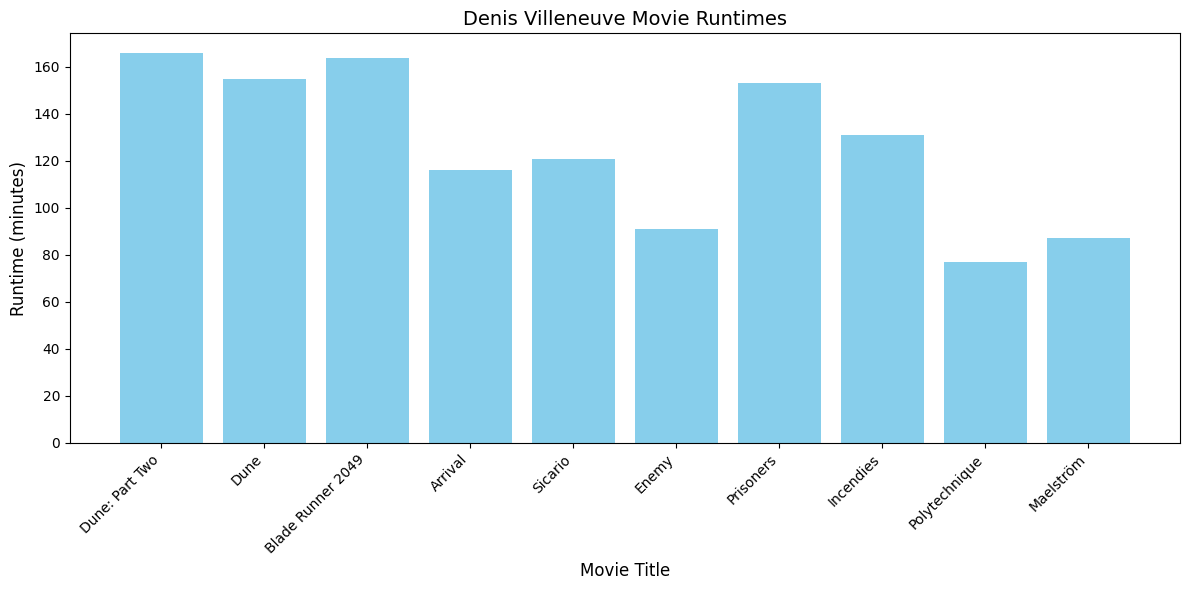

In [19]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10) # Rotate x-axis labels for better fit
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [22]:
r = movie_chat.send_message('Looks great! Can you give the chart a ominous theme instead?')
show_parts(r)

```python
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Movie titles and runtimes in minutes
movies = [
    "Dune: Part Two",
    "Dune: Part One",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Enemy",
    "Prisoners",
    "Incendies",
    "Polytechnique",
    "Maelstrom"
]

runtimes = [
    166, #Dune: Part Two
    155, #Dune: Part One
    164, #Blade Runner 2049
    116, #Arrival
    121, #Sicario
    91,  #Enemy
    153, #Prisoners
    131, #Incendies
    77,  #Polytechnique
    87   #Maelstrom
]

# Define a custom ominous color palette
colors = ['#330000', '#660000', '#990000', '#CC0000', '#FF0000', # Dark to Bright Reds
          '#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC'] # Dark Grays

# Create a colormap from the defined colors
cmap = mcolors.LinearSegmentedColormap.from_list("Ominous", colors, len(movies))

# Plotting the runtimes
plt.figure(figsize=(12, 6), facecolor='#222222')  # Adjust figure size for better readability, set dark background
ax = plt.gca()  #Get current axes
ax.set_facecolor('#222222')  # Set axes background color

plt.bar(movies, runtimes, color=cmap(range(len(movies)))) #Apply colormap to bars

plt.xlabel("Movie Title", color='white')
plt.ylabel("Runtime (minutes)", color='white')
plt.title("Denis Villeneuve - Movie Runtimes (Last 10 Films)", color='white')

plt.xticks(rotation=45, ha="right", color='white')  # Rotate movie titles for better readability
plt.yticks(color='white')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



Key changes made to create an ominous theme:

*   **Custom Color Palette:** Defined a color list `colors` ranging from dark reds to brighter reds, along with a range of dark grays.  This evokes a sense of danger and foreboding.
*   **Colormap:** Created a `LinearSegmentedColormap` from the `colors` list.  This allows us to smoothly transition between the defined colors for each bar. The colormap is named "Ominous".
*   **Bar Colors:** Applied the colormap to the bars using `color=cmap(range(len(movies)))`. This assigns a different color from the "Ominous" colormap to each bar.
*   **Figure and Axes Background Color:** Sets the figure's background color and the axes background color to a very dark gray (`#222222`) to enhance the dark and ominous feel.
*   **Text Color:** Sets the color of the axis labels, title, and tick labels to white to ensure they are clearly visible against the dark background.


Again, always be sure to review code generated by the model before running it.

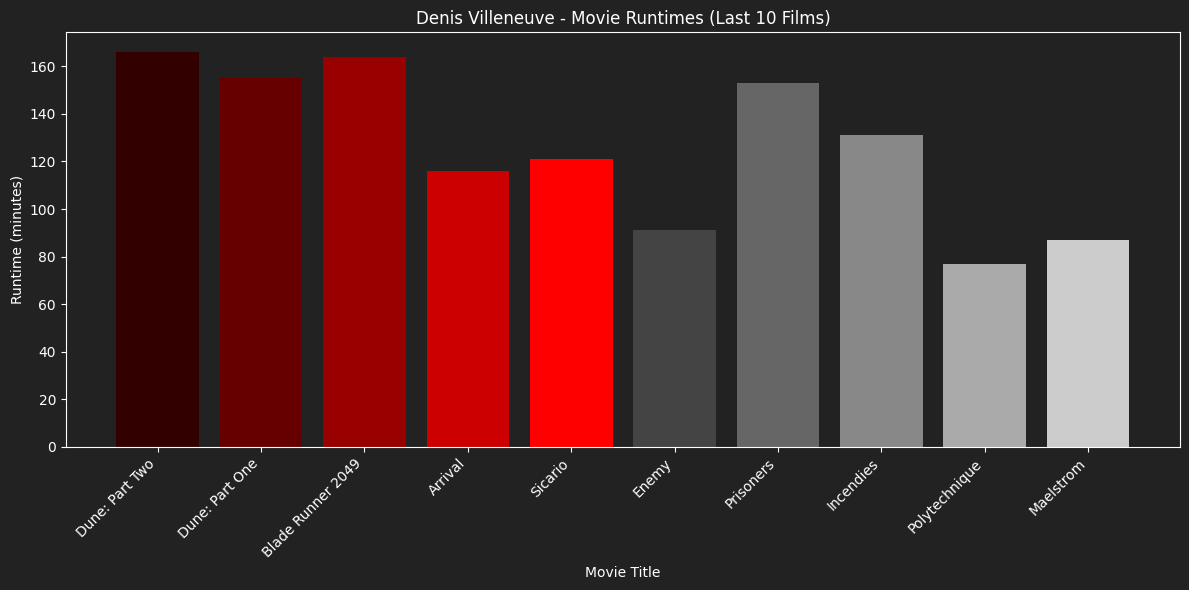

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Movie titles and runtimes in minutes
movies = [
    "Dune: Part Two",
    "Dune: Part One",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Enemy",
    "Prisoners",
    "Incendies",
    "Polytechnique",
    "Maelstrom"
]

runtimes = [
    166, #Dune: Part Two
    155, #Dune: Part One
    164, #Blade Runner 2049
    116, #Arrival
    121, #Sicario
    91,  #Enemy
    153, #Prisoners
    131, #Incendies
    77,  #Polytechnique
    87   #Maelstrom
]

# Define a custom ominous color palette
colors = ['#330000', '#660000', '#990000', '#CC0000', '#FF0000', # Dark to Bright Reds
          '#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC'] # Dark Grays

# Create a colormap from the defined colors
cmap = mcolors.LinearSegmentedColormap.from_list("Ominous", colors, len(movies))

# Plotting the runtimes
plt.figure(figsize=(12, 6), facecolor='#222222')  # Adjust figure size for better readability, set dark background
ax = plt.gca()  #Get current axes
ax.set_facecolor('#222222')  # Set axes background color

plt.bar(movies, runtimes, color=cmap(range(len(movies)))) #Apply colormap to bars

plt.xlabel("Movie Title", color='white')
plt.ylabel("Runtime (minutes)", color='white')
plt.title("Denis Villeneuve - Movie Runtimes (Last 10 Films)", color='white')

plt.xticks(rotation=45, ha="right", color='white')  # Rotate movie titles for better readability
plt.yticks(color='white')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [24]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [25]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [30]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

Buffering.......................................


Now re-run with the Search tool enabled.

In [37]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

Buffering......................................................................................


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [38]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [39]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

Buffering..........................................................................................


Now inspect the `tool_call` response(s) you received during the conversation.

In [40]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini 2.0 capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).